In [3]:
##########################################################複製區塊
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys
import meep as mp
import numpy as np
import random
import multiprocessing as multi
#setup some constants and parameters
M=2**21
tsim=7e-12
eps0 = 8.854187e-12
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12
deltap = np.sqrt(1/3/eps0/hbar/c)*kb
T=30000
frq_min = 0
frq_max = 100/2/np.pi
nfreq = 1000
fcen = (frq_min + frq_max)/2
df = frq_max - frq_min
#define square root of Dn function
def Dnsqt(wla,T):
    return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)

#generate an array of the square root of Dn function
Dsqt = []
for n in range(1,M):
    Dsqt.append(Dnsqt(2*np.pi*n/tsim,T))

#define how many times to run to average the results
Ncomp= 5
nfreq =  1000
#define the starting sum of the result
Efsum = np.zeros(nfreq)
Ens = np.zeros(2**22)
resolution = 10
dA = 0.5
dB = 0.02
dpml = 1.0
sz = dpml*2+dA*2+dB
cell = mp.Vector3(0, 0, sz)
pml_layers = [mp.PML(dpml)]



def run_single_comp(i):
    
    def random_En(t):
        #generate random numbers
        M0 = np.random.normal(0,1)
        Mlp = np.random.normal(0,1,M-1)
        Nlp = np.random.normal(0,1,M-1)
        MM = np.random.normal(0,1)
    
        #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
        #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
        #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
        Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
        Eflp = np.multiply((Mlp + 1j*Nlp), Dsqt)
        Eflm = np.flip(np.conjugate(Eflp))
        EfM = np.array([MM*Dnsqt(2*np.pi*M/tsim,T)])
        Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
        #we normalize Ef and compute its inverse fast fourier transform
        Efn = deltap*T/np.sqrt(tsim)*Ef
        En = np.fft.ifft(Efn)*M
        return En
    En0 = random_En(1)
    En1 = random_En(1)
    
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('a'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)
    
    
    def source0(t):
        f = int(t*2000)
        return En0[f]
    def source1(t):
        f = int(t*2000)
        return En1[f]

    sources = [mp.Source(mp.CustomSource(src_func=source0),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,-0.5*sz+dpml),
                     ),
              mp.Source(mp.CustomSource(src_func=source1),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,0.5*sz-dpml),
                     ),
                ]
    
    def BlockAB(N, center):
        geometry = []
        for i in range(N):
            geometry = np.append(geometry, mp.Block(mp.Vector3(0,0,dA),
                     center=mp.Vector3(0,0,0-dA/2-dB/2),
                     material=mp.Medium(epsilon=1)))
            geometry = np.append(geometry, mp.Block(mp.Vector3(0,0,dB),
                     center=mp.Vector3(0,0,0),
                     material=mp.Medium(epsilon=36)))
            geometry = np.append(geometry, mp.Block(mp.Vector3(0,0,dA),
                     center=mp.Vector3(0,0,dB/2+dA/2),
                     material=mp.Medium(epsilon=1)))
        geometry = geometry.tolist()
        return geometry
    sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,   
                    dimensions = 1,
                    Courant = 1,
                    resolution=resolution,
                    geometry=BlockAB(1,0))
    

    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(0,0,random.uniform(-0.01,0.01)))
    tran = sim.add_energy(fcen, df, nfreq, tran_fr)
    
    
    sim.run(until=2090)

    tran_flux = mp.get_magnetic_energy(tran)
    Ts = []
    for i in range(nfreq):
        Ts = np.append(Ts,tran_flux[i])    
    Efsum = Ts
    
    np.savez(str(i)+"En.npz", Efavg_30000 = Efsum)
    
    return 1
# 使用多核心處理
pool = multi.Pool()
pool.map(run_single_comp, range(Ncomp))
pool.close()
pool.join()

# 將所有結果相加
#for result in results:
    #Efsum += result



# 平均結果
Efavg = Efsum / Ncomp


[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 60%-----------
Initializing structure...


time for choose_chunkdivision = 8.60691e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 3 with resolution 10
     block, center = (0,0,-0.26)
          size (0,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     [aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 40%block, center = (0,0,0)
          size (0,0,0.02)
-----------          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (36,36,36)

     Initializing structure...block
, center = (0,0,0.26)


          size (0,0,0.5)
[aaaaaaaaaaaaaaaaaaaa] 20%          axes (1,0,0), (0,1,0), (0,0,1)
time for choose_chunkdivision = 8.79765e-05 s
          dielectric constant epsilon diagonal = (1,1,1)
Working in 1D dimensions.
time for set_epsilon = 8.10623e-05 s
-----------Computational cell is 0 x 0 x 3 with resolution 10
-----------
     
Initializing structure...block
, center = (0,0,-0.26)


          size (0,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for choose_chunkdivision = 9.70364e-05 s
          dielectric constant epsilon diagonal = (1,1,1)
Working in 1D dimensions.
     Computational cell is 0 x 0 x 3 with resolution 10
block     , center = (0,0,0)
block

FloatProgress(value=0.0, description='0% done ', max=2090.0)

          size (0,0,0.02)
[                    ] 0%, center = (0,0,-0.26)
          axes (1,0,0), (0,1,0), (0,0,1)
          size (0,0,0.5)
          dielectric constant epsilon diagonal = (36,36,36)
          axes (1,0,0), (0,1,0), (0,0,1)
               dielectric constant epsilon diagonal = (1,1,1)
block     -----------, center = (0,0,0.26)
block          size (0,0,0.5)

, center = (0,0,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Initializing structure...          size (0,0,0.02)

          dielectric constant epsilon diagonal = (1,1,1)


          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 8.70228e-05 s
          dielectric constant epsilon diagonal = (36,36,36)
time for choose_chunkdivision = 7.39098e-05 s
-----------
     Working in 1D dimensions.
Computational cell is 0 x 0 x 3 with resolution 10
block     , center = (0,0,0.26)
block          size (0,0,0.5)
, center = (0,0,-0.26)
          size (0,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
          dielectric constant epsilon diagonal = (1,1,1)
     blocktime for set_epsilon = 8.91685e-05 s


FloatProgress(value=0.0, description='0% done ', max=2090.0)

-----------
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 80%-----------

FloatProgress(value=0.0, description='0% done ', max=2090.0)


Initializing structure..., center = (0,0,0)



time for choose_chunkdivision = 6.98566e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 3 with resolution 10
     block, center = (0,0,-0.26)
          size (0,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          size (0,0,0.02)
          dielectric constant epsilon diagonal = (1,1,1)
               axes (1,0,0), (0,1,0), (0,0,1)
block          dielectric constant epsilon diagonal = (36,36,36)
, center = (0,0,0)
          size (0,0,0.02)
               axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (36,36,36)
     blockblock, center = (0,0,0.26)
, center = (0,0,0.26)
          size (0,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          size (0,0,0.5)
          dielectric constant epsilon diagonal = (1,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 5.31673e-05 s
          dielectric constant epsilon diagonal = (1,1,1)
-----------
time for set_epsilon = 5.48363e-05 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2090.0)

FloatProgress(value=0.0, description='0% done ', max=2090.0)

run 0 finished at t = 2090.0 (20900 timesteps)
run 0 finished at t = 2090.0 (20900 timesteps)
run 0 finished at t = 2090.0 (20900 timesteps)
run 0 finished at t = 2090.0 (20900 timesteps)
run 0 finished at t = 2090.0 (20900 timesteps)


/tmp/ipykernel_8051/3510127743.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


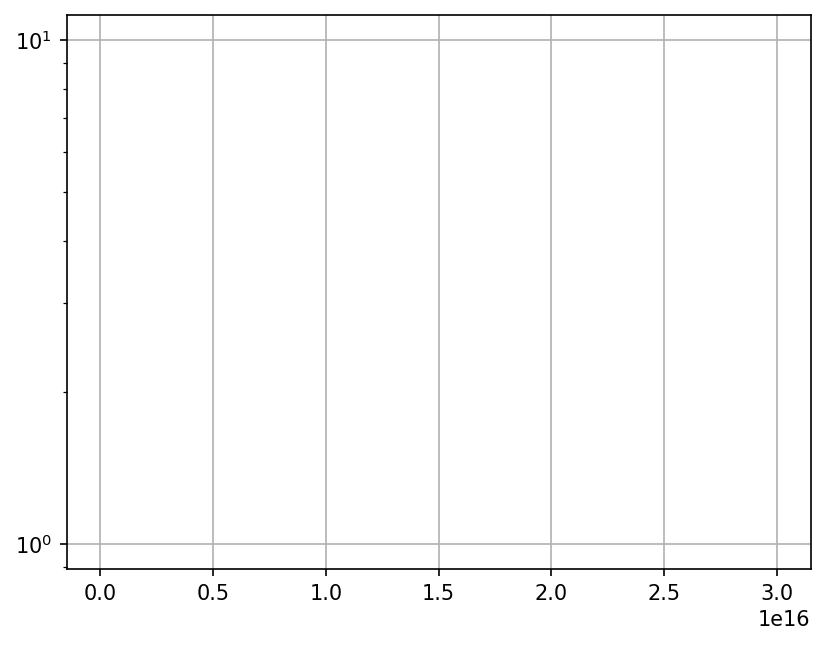

In [5]:
plt.figure(dpi=150)
freqs = np.linspace(0,30e15,1000)
plt.plot(freqs,Efavg*tsim*eps0*4*np.pi/2**21,'g''.')
plt.xlim(4e15,20e15)
plt.yscale("log")
plt.ylim(0.1e-28,400e-28)
plt.grid()
#plt.savefig('4_source_test_detector_photonic_crystal_30000.png')
plt.show()

#np.savez("test_custom_source_photonic_crystal_30000.npz", Efavg_30000 = Efavg)

In [3]:
from PIL import Image

def transPNG(srcImageName, dstImageName):
    img = Image.open(srcImageName)
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = list()
    for item in datas:
        if item[0] > 225 and item[1] > 225 and item[2] > 225:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
            
    img.putdata(newData)
    img.save(dstImageName, "PNG")
transPNG('test_detector_photonic_crystal_30000.png','trans_test_detector_photonic_crystal_30000.png')